1.Méthode de Jacobi

In [9]:
import numpy as np

def Jacobi(A, b, epsilon=0.01, K=10):
   
    # Initialisation
    n = A.shape[0]
    x0 = np.zeros(n)  
    D_inv = np.diag(1 / np.diag(A))  
    k = 0

    # Boucle itérative
    while k < K:
        k = k + 1  
        x_new = x0 + D_inv @ (b - A @ x0)  
        
        # Condition d'arrêt
        if (np.linalg.norm(x_new - x0) < epsilon):  
            return x_new  
        
        x0 = x_new  # Mise à jour de x^(k)
    
    return x0  # Retourne x_k si le nombre max d'itérations est atteint


In [10]:
# Exemple 
A = np.array([[2, 1], [3, 5]], dtype=float)
b = np.array([3, 8], dtype=float)

solution = Jacobi(A, b, epsilon=0.01, K=10)

print("Solution approchée :", solution)


Solution approchée : [0.99757 0.99757]


2.Méthode de la puissance itérée

In [ ]:
def PowerMethod(A, x0=None, epsilon=0.01, K=10):
    n = A.shape[0]
    if x0 is None:
        x0 = np.random.rand(n)
    
    #on va normaliser x0
    v = x0 / np.linalg.norm(x0)

    mu_old = 0

    for i in range(K):
        x= np.dot(A,v) #on multiplie A par v 

        v= x / np.linalg.norm(x) #on normalise x 

        mu = np.dot(v.T, np.dot(A,v))

        if abs((mu - mu_old) / mu ) < epsilon:  #on verifie le critere de convergence
            return mu,v
        
        mu_old=mu # mettre à jour mu(k-1)

    return mu,v 




In [ ]:
A = np.array([[2, 0, 4],
              [3, -4, 12],
              [1, -2, 5]])

mu, v = PowerMethod(A)

print("Valeur propre approximée:", mu)
print("Vecteur propre approximé:", v)

Valeur propre approximée: 2.0188179642486905
Vecteur propre approximé: [0.89014018 0.45565605 0.00529298]


3.Régression Polynomiale


Coefficients du polynôme de degré 3 : [ 1.13489629  5.7769809  -0.438079   -0.10100219]


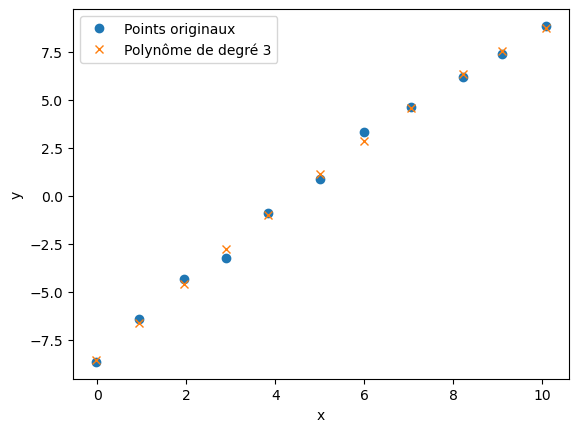

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def DetermineCoefficient(x, y, m):
    # Normalisation des données
    x_norm = (x - np.mean(x)) / np.std(x)
    n = len(x_norm)
    A = np.zeros((m + 1, m + 1))
    b = np.zeros(m + 1)

    # Remplissage de la matrice A et du vecteur b
    for j in range(m + 1):
        for i in range(n):
            b[j] += y[i] * (x_norm[i]**j)
            for k in range(m + 1):
                A[j, k] += x_norm[i]**(j + k)

    # Utilisation de la méthode de Jacobi pour résoudre Aa = b
    coeffs =Jacobi(A, b, epsilon=1e-10, K=10000)
    
    return coeffs

# Fonction pour évaluer le polynôme
def EvaluatePolynomial(coeffs, x):
    # Normalisation des valeurs de x utilisées pour l'évaluation
    x_norm = (x - np.mean(x)) / np.std(x)
    n = len(x_norm)
    m = len(coeffs) - 1
    y = np.zeros(n)

    for i in range(n):
        for j in range(m + 1):
            y[i] += coeffs[j] * (x_norm[i]**j)
    
    return y

# Données d'exemple
x = np.array([-0.04, 0.93, 1.95, 2.90, 3.83, 5.0, 5.98, 7.05, 8.21, 9.08, 10.09])
y = np.array([-8.66, -6.44, -4.36, -3.27, -0.88, 0.87, 3.31, 4.63, 6.19, 7.4, 8.85])

m = 3  # Degré du polynôme

# Calcul des coefficients du polynôme de degré 3
coeffs = DetermineCoefficient(x, y, m)
print("Coefficients du polynôme de degré 3 :", coeffs)

# Évaluation du polynôme aux points x
y_eval = EvaluatePolynomial(coeffs, x)

# Tracer les deux nuages de points
plt.figure()

# Nuage de points originaux (x, y)
plt.plot(x, y, 'o', label='Points originaux')

# Nuage de points pour le polynôme de degré 3 (x, p(x))
plt.plot(x, y_eval, 'x', label='Polynôme de degré 3')

# Ajouter des labels et une légende
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Afficher le graphique
plt.show()


4. Interpolation par splines cubiques


In [45]:
def DeterminePSecond(x, y):
    n = len(x) - 1  # Nombre de segments
    h = np.diff(x)   # Calcul des intervalles h_i = x_{i+1} - x_i
    
    # Initialiser les vecteurs alpha, beta, gamma et le vecteur c
    alpha = np.zeros(n-1)
    beta = np.zeros(n-1)
    gamma = np.zeros(n-1)
    c = np.zeros(n-1)

    # Calcul des coefficients alpha, beta, gamma
    for i in range(1, n):
        alpha[i-1] = h[i-1]
        beta[i-1] = 2 * (h[i-1] + h[i])
        gamma[i-1] = h[i]
        c[i-1] = 6 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    # Construire la matrice tridiagonale A et résoudre A*p = c
    A = np.zeros((n-1, n-1))
    for i in range(n-1):
        if i > 0:
            A[i, i-1] = alpha[i-1]
        A[i, i] = beta[i-1]
        if i < n-2:
            A[i, i+1] = gamma[i]

    # Résoudre le système Ap = c
    p_internal = np.linalg.solve(A, c)

    # Ajouter les contraintes p_0 = 0 et p_n = 0 (pentes nulles aux extrémités)
    p = np.zeros(n+1)
    p[1:n] = p_internal

    return p


In [46]:
def ComputeSplineInterpolation(x, y, p, x_new):
    n = len(x) - 1  # Nombre de segments
    y_new = np.zeros(len(x_new))
    
    h = np.diff(x)   # Calcul des intervalles h_i = x_{i+1} - x_i
    
    # Interpolation pour chaque point dans x_new
    for i_new, xi_prime in enumerate(x_new):
        for i in range(n):
            if x[i] <= xi_prime <= x[i+1]:
                hi = h[i]
                alpha_i = (y[i+1] - y[i]) / hi - (hi * (p[i+1] - p[i])) / 6
                beta_i = y[i]
                
                y_new[i_new] = (p[i+1] * (xi_prime - x[i])**3) / (6 * hi) \
                              - (p[i] * (xi_prime - x[i+1])**3) / (6 * hi) \
                              + alpha_i * (xi_prime - x[i]) + beta_i
                break
    
    return y_new

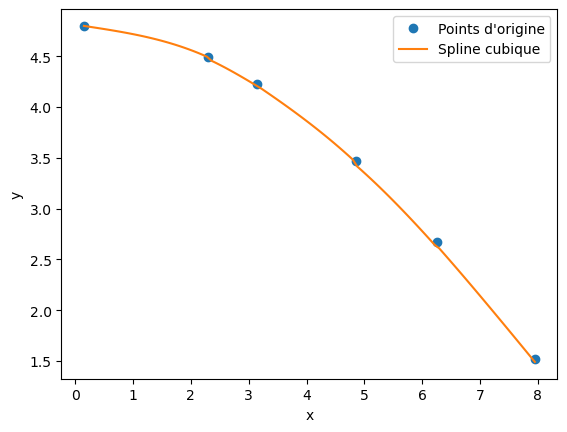

In [47]:
# Données d'exemple
x = np.array([0.15, 2.3, 3.15, 4.85, 6.25, 7.95])
y = np.array([4.79867, 4.49013, 4.2243, 3.47313, 2.66674, 1.51909])

# Calculer les dérivées secondes
p = DeterminePSecond(x, y)

# Points d'interpolation
x_new = np.linspace(min(x), max(x), 100)

# Calculer les valeurs interpolées
y_new = ComputeSplineInterpolation(x, y, p, x_new)

# Tracer les résultats
plt.plot(x, y, 'o', label='Points d\'origine')
plt.plot(x_new, y_new, '-', label='Spline cubique')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

5. Méthode de dichotomie

In [49]:

def BisectionMethod(f, a, b, epsilon):

     # Vérifier que f(a) et f(b) sont de signes opposés
    if f(a) * f(b) >= 0:
        raise ValueError("f(a) et f(b) doivent avoir des signes opposés")
    

   # Initialisation des variables
    a_k = a
    b_k = b
    c_k = (a_k + b_k) / 2
    n = int(np.ceil(np.log((b - a) / epsilon) / np.log(2)))

    # Boucle pour n itérations
    for k in range(1, n+1):        
        # Vérifier la condition d'arrêt
        if f(a_k) * f(c_k) <= 0:
            if f(c_k) == 0:
                return c_k
            b_k = c_k
        else:
            a_k = c_k
        
        c_k = (a_k + b_k) / 2

    return c_k



In [50]:
# Définir la fonction donnée
def f(x):
    return x**3 + x - 1  # Fonction f(x) = x^3 + x - 1

# Intervalle [a, b] et précision epsilon
a = 0
b = 1
epsilon = 0.001

# Appeler la méthode de dichotomie
root = BisectionMethod(f, a, b, epsilon)
print("Racine trouvée :", root)

Racine trouvée : 0.68212890625


6. Méthode de la fausse position modifiée

In [52]:
def ModifiedRegulafalsiMethod(f, a, b, epsilon):
    # Vérifier que f(a) et f(b) sont de signes opposés
    if f(a) * f(b) >= 0:
        raise ValueError("f(a) et f(b) doivent avoir des signes opposés")

    # Initialisation des variables
    k = 1
    a_k = a
    b_k = b
    c_k = (a_k * f(b_k) - b_k * f(a_k)) / (f(b_k) - f(a_k))
    prev_c_k = None  # Pour stocker la valeur précédente de c_k

    # Boucle principale
    while abs(f(c_k)) > epsilon:
        k = k + 1
        alpha = 1
        beta = 1

        if f(a_k) * f(c_k) < 0:
            b_k = c_k
            if prev_c_k is not None and f(prev_c_k) * f(c_k) > 0:
                alpha = 1 / 2
            # Mettre à jour c_k en utilisant les valeurs pondérées de a_k et b_k
            c_k = (beta * b_k * f(a_k) - alpha * a_k * f(b_k)) / (beta * f(a_k) - alpha * f(b_k))
        else:
            a_k = c_k
            if prev_c_k is not None and f(prev_c_k) * f(c_k) > 0:
                beta = 1 / 2
            # Mettre à jour c_k en utilisant les valeurs pondérées de a_k et b_k
            c_k = (beta * b_k * f(a_k) - alpha * a_k * f(b_k)) / (beta * f(a_k) - alpha * f(b_k))

        # Stocker la valeur précédente de c_k pour la prochaine itération
        prev_c_k = c_k

    return c_k


In [54]:
# Définir la fonction f(x)
def f(x):
    return x**3 + x - 1

# Définir l'intervalle et la précision
a = 0
b = 1
epsilon = 0.001

# Appeler la méthode de la fausse position modifiée
root = ModifiedRegulafalsiMethod(f, a, b, epsilon)
print("Racine trouvée :", root)


Racine trouvée : 0.6819735421424331


7. Méthode de Newton 

In [55]:
def NewtonMethod(f, f_prime, x0, epsilon, delta, K):
    k = 0
    x_k = x0
    
    while True:
        k += 1
        # Calculer la nouvelle valeur de x_k
        x_k_new = x_k - f(x_k) / f_prime(x_k)
        
        # Vérifier la condition d'arrêt
        if abs(f(x_k_new)) < epsilon or abs(x_k_new - x_k) < delta:
            return x_k_new
        
        # Si la dérivée est nulle, arrêter
        if k >= K or f_prime(x_k) == 0:
            return "Pas de racine trouvée"
        
        # Mettre à jour x_k pour la prochaine itération
        x_k = x_k_new


In [56]:
# Définir la fonction et sa dérivée
def f(x):
    return x**3 + x - 1  # Fonction f(x) = x^3 + x - 1

def f_prime(x):
    return 3*x**2 + 1  # Dérivée de f(x)

# Paramètres de la méthode
x0 = 0.5  # Point de départ
epsilon = 0.001  # Précision sur la fonction
delta = 0.001  # Précision sur la différence entre x_k et x_k-1
K = 10  # Nombre maximal d'itérations

# Appeler la méthode de Newton
root = NewtonMethod(f, f_prime, x0, epsilon, delta, K)
print("Racine trouvée :", root)

Racine trouvée : 0.6823284233045783


8. La méthode de trapèze composite


In [57]:
def compositeTrapezoidalRule(f,m,a,b):
    h=(b-a)/m    #m taille de segment 

    l=0 
    for i in range(m+1):
        x_i=a+ i*h #calcul du point x_i
        if (i==0) or (i==m):
            l=l+ f(x_i)
        else: 
            l=l+2*f(x_i)

    return l*(h/2)

In [58]:
def f(x):
    return np.sin(x)

a=0
b=np.pi

#test avec 8 seg 
appox_8_seg=compositeTrapezoidalRule(f,8,a,b)
print ("Appro avec 8 seg :",appox_8_seg)

#test avec 16 seg 
appox_16_seg=compositeTrapezoidalRule(f,16,a,b)
print ("Appro avec 16 seg :",appox_16_seg)


Appro avec 8 seg : 1.9742316019455508
Appro avec 16 seg : 1.9935703437723395


9. Méthode de Simpson Composite 


In [59]:
def compositeSimpsonRule(f,m,a,b):
    if m % 2 != 0 :
        print('m doir etre paire ')
        raise ValueError ('m doir etre paire')
    
    h= (b-a) / m 
    l=0
    
    for i in range (m+1):
        x_i=a+ i*h #calcul du point x_i

        if (i==0) or (i==m):
            l = l+f(x_i)
        elif i % 2 ==0 : #si i paire
            l= l + 2*f(x_i)
        else :
            l= l + 4*f(x_i)  #si i impaire
    
    return l*(h/3)

In [60]:
def g(x):
    return np.sin(x)

a=0
b=np.pi

#test avec 8 seg 
appox_8_seg=compositeSimpsonRule(g,8,a,b)
print ("Appro avec 8 seg :",appox_8_seg)

#test avec 16 seg 
appox_16_seg=compositeSimpsonRule(g,16,a,b)
print ("Appro avec 16 seg :",appox_16_seg)

Appro avec 8 seg : 2.000269169948388
Appro avec 16 seg : 2.0000165910479355


10. Méthode de Romberg

In [74]:
import numpy as np

# Fonction d'extrapolation de Richardson
def RichardsonExtrapolation(a, b, j):
    return (4**(j-1) * a - b) / (4**(j-1) - 1)

# Intégration de Romberg
def RombergIntegration(f, a, b, eps, K):
    # Initialisation de la matrice R avec la taille K x K
    R = np.zeros((K, K))
    R[1, 1] = compositeTrapezoidalRule(f, 1, a, b)
    
    for i in range(2, K+1):
        # Calcul de R[i,0] avec 2^i segments
        R[i, 1] = compositeTrapezoidalRule(f, 2**i, a, b)
        Rold = R[i, 1]

        for j in range(2, i + 1):
            # Application de l'extrapolation de Richardson
            R[i, j] = RichardsonExtrapolation(R[i, j-1], R[i-1, j-1], j)
            
            # Vérification de la convergence
            if np.abs(R[i, j] - Rold) < eps:
                return R[i, j]
            else:
                Rold = R[i, j]

    return Rold

In [75]:
# Définition de la fonction à intégrer
def f(x):
    return np.sin(x)

# Paramètres de l'intégration
a = 0
b = np.pi
epsilon = 0.001
K = 10  # Nombre d'itérations

# Calcul de l'intégrale avec la méthode de Romberg
result_romberg = RombergIntegration(f, a, b, epsilon, K)
print("Approximation de l'intégrale avec Romberg :", result_romberg)

Approximation de l'intégrale avec Romberg : 1.9999997524545725
